<a href="https://colab.research.google.com/github/mafaldasalomao/multilabel_classification_pocus/blob/main/multilabel_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import suppporting libraries
import tarfile
import urllib.request as urllib2
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
#Import deep learning libraries
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tqdm as tqdm
import tensorflow_hub as hub

#Import data analytics libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
#Import image visualization libraries
from PIL import *
from PIL import ImageFile
from PIL import Image
#System settings
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['WANDB_CONSOLE'] = 'off'
#Coloring for print outputs
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [ ]:
!nvidia-smi

Thu Dec 22 19:40:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp  /content/drive/MyDrive/datasets/convex.zip /content/

In [5]:
!cp /content/drive/MyDrive/datasets/dataset_metadata.csv /content/

In [6]:
!unzip -q convex.zip -d /content/temp

In [7]:
path='/content/temp/convex'
annotation_path = "dataset_metadata.csv"
videos_list = os.listdir(path)

In [8]:
columns = ['Filename', 'Effusion', 'Consolidations', 'B-lines', 'A-lines', 'Pleural_line_irregularities', 'Air_bronchogram', 'Label']
base = pd.read_csv(annotation_path, usecols=columns)

In [9]:
base = base[base['Effusion'] != 'n/A']
base = base[base['Consolidations'] != 'n/A']
base = base[base['B-lines'] != 'n/A']
base = base[base['A-lines']  != 'n/A']
base = base[base['Pleural_line_irregularities']  != 'n/A']
base = base[base['Air_bronchogram']  != 'n/A']
base = base[base['Label']  != 'n/A']
#base = base[base['Label']  != 'regular']
#base = base[base['Label']  != 'Regular']
base['Label']= base['Label'].replace(['regular'], 'Regular')

base['Effusion'] = pd.to_numeric(base['Effusion'])
base.head()

,Filename,Label,Effusion,Consolidations,B-lines,A-lines,Pleural_line_irregularities,Air_bronchogram
0,Cov-Butterfly-COVID Lung 2,COVID-19,1.0,0.0,1.0,0.0,1.0,0.0
1,Cov-Butterfly-Skip Lesion,COVID-19,0.0,1.0,1.0,1.0,1.0,0.0
2,Cov-Butterfly-Confluent B lines,COVID-19,0.0,0.0,1.0,0.0,0.0,0.0
3,Reg-Butterfly-Normal Lung A lines,Regular,0.0,0.0,0.0,1.0,0.0,0.0
4,Reg-Butterfly-Normal Lung_Example 2,Regular,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
base  = base.dropna(axis = 0)
base.shape

(346, 8)

In [11]:
metadata = base;
metadata['Filename']

0               Cov-Butterfly-COVID Lung 2
1                Cov-Butterfly-Skip Lesion
2          Cov-Butterfly-Confluent B lines
3        Reg-Butterfly-Normal Lung A lines
4      Reg-Butterfly-Normal Lung_Example 2
                      ...                 
344                Cov-B_ConvexProb_score1
345               Cov-C_Convex_Prob_score2
346               Cov-D_Convex_Prob_score3
347                Cov-C_ConvexProb_score3
348                    Cov-MSU-SkipLesions
Name: Filename, Length: 346, dtype: object

In [12]:
#"Cov-Butterfly-COVID Lung 2" in metadata['Filename']
teste = metadata.loc[metadata.Filename == "Reg-Atlas-lungcurtain"]
len(teste)

1

In [13]:
effusion_list = []
consolid_list = []
aline_list = []
bline_list = []
pli_list = []
airb_list = []
filenames = []
y_labels = []
num_imgs_per_video = 10
path_imgs_train = '/content/drive/MyDrive/datasets/imgs'
#os.mkdir(path_imgs_train)
os.mkdir("/content/dataset")

In [14]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
num_imgs_per_video=10

In [ ]:

feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
feature_extractor_layer.trainable = True

In [15]:
def plot_curves(history, title):
    fig_1 = plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['loss'])+1)
    plt.plot(epochs, history.history['loss'], label="Train loss")
    plt.plot(epochs, history.history['val_loss'], label="Test Loss")
    plt.title("Training Loss Curve: "+title)
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.legend();
    fig_1.savefig(path_imgs_train+'/loss_'+title+'.png')
    plt.close(fig_1)
    
    fig_2 = plt.figure(figsize=(5, 3))
    epochs = range(1, len(history.history['accuracy'])+1)
    plt.plot(epochs, history.history['accuracy'], label="Train Acc")
    plt.plot(epochs, history.history['val_accuracy'], label="Test Acc")
    plt.title("Training Accuracy Curve: "+title)
    plt.ylabel("Accuracy")
    plt.xlabel("Epochs")
    plt.legend();
    fig_2.savefig(path_imgs_train+'/acc_'+title+'.png')
    plt.close(fig_2)

## Data Augmentation


In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations

In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, ElasticTransform, GridDistortion, OpticalDistortion, CoarseDropout

In [ ]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

In [ ]:
from scipy.stats.distributions import alpha
def create_dataset_aug(img_altura=224, img_largura=224, augmentation=True):
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = '/content/dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    cv2.imwrite(out, image)
                    img = tf.keras.utils.load_img(out, target_size = (img_largura, img_altura, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    X_train.append(img)
                    img_labels = [metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]],
                                    metadata['Pleural_line_irregularities'][metadata_cap.index[0]]]
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                    y_train.append(img_labels)
                    if augmentation:
                      aug = HorizontalFlip(p = 1.0)
                      augmentation = aug(image = img)
                      x1 = augmentation['image']
                      X_train.append(x1)
                      y_train.append(img_labels)

                      aug = OpticalDistortion(p = 1.0, distort_limit=2, shift_limit=0.5)
                      augmentation = aug(image = img)
                      x2 = augmentation['image']
                      X_train.append(x2)
                      y_train.append(img_labels)

                      # aug = ElasticTransform(p = 1.0, alpha=120, sigma=120*0.05, alpha_affine=120*0.03)
                      # augmentation = aug(image = img)
                      # x3 = augmentation['image']
                      # X_train.append(x3)
                      # y_train.append(img_labels)

                      # aug = GridDistortion(p = 1.0)
                      # augmentation = aug(image = img)
                      # x4 = augmentation['image']
                      # X_train.append(x4)
                      # y_train.append(img_labels)

                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [16]:
def create_mydataset_all():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = '/content/dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    cv2.imwrite(out, image)
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 3))
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]],
                                    metadata['Pleural_line_irregularities'][metadata_cap.index[0]]])
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [17]:
#X, y = create_dataset_aug()
X, y = create_mydataset_all()
#((1225, 224, 224, 3), (1225, 5))
num_folds=5
# Define the K-fold Cross Validator
#kfold = KFold(n_splits=num_folds, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
del X
del y
#X_train.shape, y_train.shape

In [ ]:
from keras import initializers
#tf.random.set_seed(42)
N_LABELS = 5
EPOCHS = 20
batch_size = 32
LR = 0.0001
acc_per_fold = []
loss_per_fold = []

In [ ]:
reconstructed_model = keras.models.load_model("my_h5_model.h5")

## K-fold train

In [ ]:
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):
  N_LABELS = 5
  EPOCHS = 30
  LR = 1e-4
  batch_size = 32
  ##################
  #2048-5 = 
  initializer = tf.keras.initializers.Identity()
  model_all_0 = tf.keras.Sequential([
      feature_extractor_layer_resnet,
      Dense(512, activation='relu', name='hidden_layer_1'),
      Dense(512, activation='relu', name='hidden_layer_2'),
      Dense(128, activation='relu', name='hidden_layer_3'),
      Dense(N_LABELS, activation='sigmoid', name='output')
  ])
  # Compile the model
  model_all_0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    loss='binary_crossentropy',
    metrics=['accuracy'])

  history = model_all_0.fit(X[train], y[train],
              batch_size=batch_size,
              epochs=EPOCHS,
              validation_data=(X[test], y[test]))

  # Generate generalization metrics
  scores = model_all_0.evaluate(X[test], y[test], verbose=1)
  print(f'Score for fold {fold_no}: {model_all_0.metrics_names[0]} of {scores[0]}; {model_all_0.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


## Backbone resnet101

In [18]:
feature_extractor_url_resnet = "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/5"
feature_extractor_layer_resnet = hub.KerasLayer(feature_extractor_url_resnet,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
feature_extractor_url_eff = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"
feature_extractor_layer_eff = hub.KerasLayer(feature_extractor_url_resnet,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [ ]:
print("Thickness of the model:", len(feature_extractor_layer_resnet.weights))
#list(feature_extractor_layer_resnet.layers)

In [19]:
feature_extractor_layer_resnet.trainable = False

In [ ]:
#X, y = create_dataset_aug()
X, y = create_mydataset_all()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape
del X
del y

In [ ]:
#tf.random.set_seed(42)

## Unit Test

In [20]:
dense = [2048, 1024, 512, 256, 128, 64, 32, 16, 10, 5]

In [ ]:
tested = 474
for i in range(len(dense)):
  for j in range(len(dense)-i):
    for k in range(len(dense)-j-i):
      for l in range(len(dense)-j-i-k):
        if tested >-1:
          a=1
        else:
          title = '2048_'+str(dense[i])+'_'+str(dense[j+i])+'_'+str(dense[k+j+i])+'_'+str(dense[k+j+i+l])
          print(title)
        tested = tested-1

In [ ]:
tested = 474
for i in range(len(dense)):
  for j in range(len(dense)-i):
    for k in range(len(dense)-j-i):
      for l in range(len(dense)-j-i-k):
        if tested >-1:
          a=1
        else:
          N_LABELS = 5
          EPOCHS = 30
          LR = 1e-4
          batch_size = 32
          ##################
          #2048-5 = 
          initializer = tf.keras.initializers.Identity()
          model_all_0 = tf.keras.Sequential([
              feature_extractor_layer_resnet,
              Dense(2048, activation='relu', name='hidden_layer_1'),
              Dense(dense[i], activation='relu', name='hidden_layer_2'),
              Dense(dense[j+i], activation='relu', name='hidden_layer_3'),
              Dense(dense[k+j+i], activation='relu', name='hidden_layer_4'),
              Dense(dense[k+j+i+l], activation='relu', name='hidden_layer_5'),
              Dense(N_LABELS, activation='sigmoid', name='output')
          ])
          # Compile the model

          model_all_0.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
            loss='binary_crossentropy',
            metrics=['accuracy'])

          history = model_all_0.fit(X_train, y_train,
                      batch_size=batch_size,
                      epochs=EPOCHS,
                      validation_data=(X_test, y_test))
          title = title = '2048_'+str(dense[i])+'_'+str(dense[j+i])+'_'+str(dense[k+j+i])+'_'+str(dense[k+j+i+l])+'_5'
          print("Model: "+title)
          print("=================================================================================")
          plot_curves(history, title)
        tested = tested -1

Epoch 1/30
39/39 [==============================] - 25s 241ms/step - loss: 0.5471 - accuracy: 0.2343 - val_loss: 0.4197 - val_accuracy: 0.2313
Epoch 2/30
39/39 [==============================] - 7s 177ms/step - loss: 0.3197 - accuracy: 0.3576 - val_loss: 0.2648 - val_accuracy: 0.4853
Epoch 3/30
39/39 [==============================] - 7s 177ms/step - loss: 0.1840 - accuracy: 0.5200 - val_loss: 0.1742 - val_accuracy: 0.5668
Epoch 4/30
39/39 [==============================] - 7s 177ms/step - loss: 0.1102 - accuracy: 0.5657 - val_loss: 0.1225 - val_accuracy: 0.5505
Epoch 5/30
39/39 [==============================] - 7s 179ms/step - loss: 0.0727 - accuracy: 0.5894 - val_loss: 0.0912 - val_accuracy: 0.5863
Epoch 6/30
39/39 [==============================] - 7s 179ms/step - loss: 0.0453 - accuracy: 0.5886 - val_loss: 0.0787 - val_accuracy: 0.5505
Epoch 7/30
39/39 [==============================] - 7s 183ms/step - loss: 0.0297 - accuracy: 0.6057 - val_loss: 0.0459 - val_accuracy: 0.5668
Epoch

In [ ]:
!zip -r data.zip imgs/

In [ ]:

base_model.trainable = True
# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

## Experiments




### Approved model


In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


In [ ]:
IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 1 # Keep RGB color channels to match the input format of the model
num_imgs_per_video=10

In [ ]:
def create_mydataset_all_gray():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = '/content/dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]],
                                    metadata['Pleural_line_irregularities'][metadata_cap.index[0]]])
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [ ]:
#X, y = create_dataset_aug()
X, y = create_mydataset_all_gray()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape
del X
del y

In [ ]:

#BUild a CNN model ( some as Tiny VGG on the CNN exlpainer website)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224,224,1)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    #tf.keras.layers.Activations(tf.nn.relu),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(28090, activation='relu'),
    tf.keras.layers.Dense(5, activation="sigmoid")
])


In [ ]:
X_train.shape

(1225, 224, 224, 3)

In [ ]:
#compile our model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])
1500/32
#fit the model
history_1 = model_1.fit(X_train, y_train,
                        epochs=5,
                        validation_data=(X_test, y_test))

Epoch 1/5
39/39 [==============================] - 85s 2s/step - loss: 7.9560e-04 - accuracy: 0.5714 - val_loss: 0.0480 - val_accuracy: 0.5537
Epoch 2/5
39/39 [==============================] - 93s 2s/step - loss: 4.6626e-04 - accuracy: 0.5788 - val_loss: 0.0508 - val_accuracy: 0.6417
Epoch 3/5
39/39 [==============================] - 92s 2s/step - loss: 3.6175e-04 - accuracy: 0.5820 - val_loss: 0.0466 - val_accuracy: 0.5668
Epoch 4/5
39/39 [==============================] - 84s 2s/step - loss: 2.7442e-04 - accuracy: 0.5804 - val_loss: 0.0516 - val_accuracy: 0.5537
Epoch 5/5
39/39 [==============================] - 86s 2s/step - loss: 2.0482e-04 - accuracy: 0.5690 - val_loss: 0.0516 - val_accuracy: 0.5700


In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      100       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
preds = model_1.predict(X_test)
preds = np.array(preds> 0.5) #limiar
preds

10/10 [==============================] - 6s 557ms/step


array([[False, False, False,  True, False],
       [False, False, False, False, False],
       [False, False, False, False, False],
       ...,
       [False, False, False,  True, False],
       [False,  True, False, False, False],
       [False,  True, False, False, False]])

In [ ]:
def plot_results(y_test, preds):
  effusion_list_preds = []
  consolid_list_preds = []
  aline_list_preds = []
  bline_list_preds = []
  pli_list_preds = []
  effusion_list= []
  consolid_list = []
  aline_list = []
  bline_list = []
  pli_list = []
  for i in range(len(preds)):
    aline_list_preds.append(preds[i][0])
    bline_list_preds.append(preds[i][1])
    effusion_list_preds.append(preds[i][2])
    consolid_list_preds.append(preds[i][3])
    pli_list_preds.append(preds[i][4])
    aline_list.append(y_test[i][0])
    bline_list.append(y_test[i][1])
    effusion_list.append(y_test[i][2])
    consolid_list.append(y_test[i][3])
    pli_list.append(y_test[i][4])
  acc_aline = accuracy_score(aline_list, aline_list_preds)
  print('The accuracy for A-Line: ', acc_aline)
  acc_bline = accuracy_score(bline_list, bline_list_preds)
  print('The accuracy for B-Line: ', acc_bline)
  acc_aline = accuracy_score(aline_list, aline_list_preds)
  print('The accuracy for A-Line: ', acc_aline)
  acc_aline = accuracy_score(aline_list, aline_list_preds)
  print('The accuracy for A-Line: ', acc_aline)
  acc_aline = accuracy_score(aline_list, aline_list_preds)
  print('The accuracy for A-Line: ', acc_aline)
  matriz_aline = confusion_matrix(aline_list, aline_list_preds)
  ax1 = plt.axes()
  sns.heatmap(matriz_aline, annot=True);
  ax1.set_title('A-Lines')
  plt.show()
  ax2 = plt.axes()
  matriz_bline = confusion_matrix(bline_list, bline_list_preds)
  sns.heatmap(matriz_bline, annot=True);
  ax2.set_title('B-Lines')
  plt.show()
  matriz_effusion = confusion_matrix(effusion_list, effusion_list_preds)
  ax3 = plt.axes()
  sns.heatmap(matriz_effusion, annot=True);
  ax3.set_title('Effusion')
  plt.show()
  matriz_consolidations = confusion_matrix(consolid_list, consolid_list_preds)
  ax4 = plt.axes()
  sns.heatmap(matriz_consolidations, annot=True);
  ax4.set_title('Consolidations')
  plt.show()
  matriz_pli = confusion_matrix(pli_list, pli_list_preds)
  ax3 = plt.axes()
  sns.heatmap(matriz_pli, annot=True);
  ax3.set_title('Pleural Irregularities')
  plt.show()
  print(matriz_aline)
  print(matriz_bline)
  print(matriz_effusion)
  print(matriz_consolidations)
  print(matriz_pli)

The accuracy was:  0.993485342019544


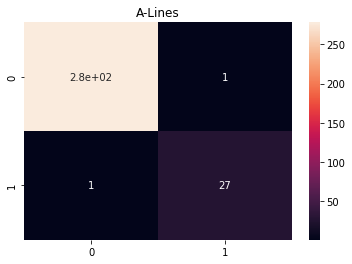

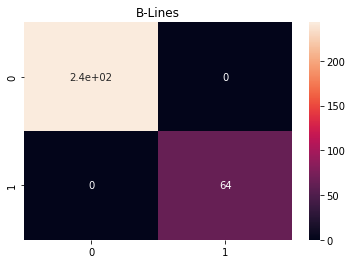

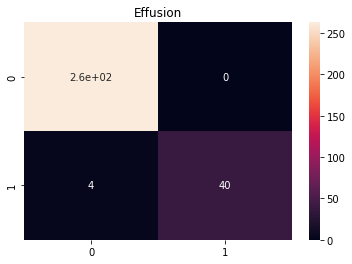

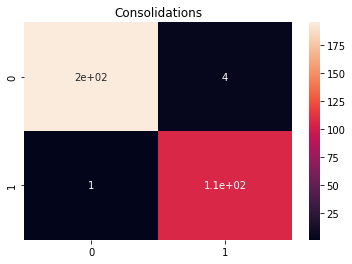

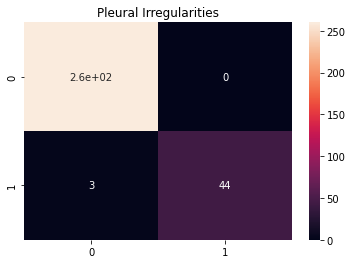

[[278   1]
 [  1  27]]
[[243   0]
 [  0  64]]
[[263   0]
 [  4  40]]
[[195   4]
 [  1 107]]
[[260   0]
 [  3  44]]


In [ ]:
plot_results(y_test, preds)

In [ ]:
#train (80%(80%) #Validation(20%)) %teste(20%)
#set random seed
tf.random.set_seed(42)

#create the model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
#compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
#fit the model
history_3=model_3.fit(train_data,
            epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))